In [ ]:
%cd "/gscratch/xlab/alisaliu/superbpe"

/mmfs1/gscratch/xlab/alisaliu/pretokenization


/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import read_json, get_pretokenization_regex
from pathlib import Path
from collections import Counter
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import GradientHandler
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import nltk
from transformers import AutoTokenizer
import regex as re
from constants import POS_TO_GROUP

# Play with segmentations

In [3]:
tokenizer_name = "olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon"
tokenizer = AutoTokenizer.from_pretrained(str(Path('tokenizer_json') / tokenizer_name))

In [4]:
'|'.join([tokenizer.decode(tok) for tok in tokenizer.encode("By the way, I am a fan of the Milky Way.")])

'By the way|, I am| a| fan| of the| Milky Way|.'

# POS tags

In [5]:
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to
[nltk_data]     /mmfs1/home/alisaliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /mmfs1/home/alisaliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
tokenizer_name = "olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon"
token_to_id = read_json(f'tokenizer_json/{tokenizer_name}/tokenizer.json')['model']['vocab']
id_to_token = {v: k for k, v in token_to_id.items()}
tokenizer = AutoTokenizer.from_pretrained(f"tokenizer_json/{tokenizer_name}")

In [7]:
pattern = get_pretokenization_regex(f"tokenizer_json/olmo2_p99_truncate_pretok_10G_200K/tokenizer.json")
data = []
multiword = []
for token, token_id in tqdm(token_to_id.items()):
    text = tokenizer.decode([token_id])
    matches = [(match.group(), match.span()) for match in re.finditer(pattern, text)]
    data.append({
        "token": token,
        "token_id": token_id,
        "num_subwords": len(matches),
        "num_words": len([word for word in tokenizer.decode(token_id).split(' ') if not (word == '' or word.isspace())])
    })

  0%|          | 0/200000 [00:00<?, ?it/s]

In [8]:
token_df = pd.DataFrame(data)

In [9]:
pos_tags = []
for i, row in tqdm(token_df.iterrows(), total=len(token_df.index)):
    token = tokenizer.decode(row['token_id'])
    pos_tag = tuple(w[1] for w in nltk.pos_tag(nltk.word_tokenize(token)))
    pos_tags.append(pos_tag)
token_df['pos'] = pos_tags

  0%|          | 0/200000 [00:00<?, ?it/s]

In [10]:
token_df.to_json(f'tokenizer_json/{tokenizer_name}/token_pos.jsonl', lines=True, orient='records')

In [11]:
token_df = pd.read_json(f'tokenizer_json/{tokenizer_name}/token_pos.jsonl', lines=True)
token_df['pos'] = [tuple([POS_TO_GROUP.get(p, p) for p in pos]) for pos in token_df.pos]

In [12]:
# show most common POS tags for each n-gram length, along with random examples
sub_df = token_df.loc[token_df['num_words'] == 3]
pos_counter = Counter(sub_df.pos.tolist())

for pos_tag, count in pos_counter.most_common(10):
    exs = [tokenizer.decode(token_id) for token_id in sub_df.loc[sub_df['pos'] == pos_tag].sample(5)["token_id"].tolist()]
    exs = ", ".join([f'"{ex}"' for ex in exs])
    print(f'pos: {pos_tag}, count: {count}, examples: {exs}')

pos: ('IN', 'DT', 'NN'), count: 333, examples: " at any time", " in the past", " throughout the world", "By the time", " at a time"
pos: ('NN', 'IN', 'DT'), count: 270, examples: " values of the", " note that the", " suggest that the", " think of the", " role in the"
pos: ('IN', 'DT', 'JJ'), count: 145, examples: " in the original", " of the first", " with a few", " for the next", " of the modern"
pos: ('VB', 'IN', 'DT'), count: 121, examples: " caused by a", " go through the", " argued that the", " included in the", " went into the"
pos: ('.', 'PRP', 'VB'), count: 84, examples: ". You need", ". You know", ". I started", ". He had", ". They have"
pos: ('IN', 'PRP', 'VB'), count: 69, examples: " because it was", " if you were", " that he was", " of us are", " that I am"
pos: ('TO', 'VB', 'DT'), count: 67, examples: " to take a", " to ensure the", " to create a", " to write a", " to leave the"
pos: (',', 'PRP', 'VB'), count: 66, examples: ", I know", ", I had", ", you have", ", you do", 

# What subword indices are used in superword tokens?

In [13]:
tokenizer_name = "olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon"
tokenizer_json = read_json(f'tokenizer_json/{tokenizer_name}/tokenizer.json')['model']
merges = [tuple(m) for m in tokenizer_json['merges']]

In [14]:
token_to_id = tokenizer_json['vocab']
id_to_token = {i: tok for tok, i in token_to_id.items()}

In [15]:
first_superword_merge = [i for i, m in enumerate(merges) if m == ('.', 'Ċ')][0]
first_superword_merge

179991

In [16]:
used_tokens = []
for m in merges[first_superword_merge:]:
    token = ''.join(m)
    superword_id = token_to_id[token]
    l_id, r_id = token_to_id[m[0]], token_to_id[m[1]]
    used_tokens.extend([l_id, r_id])

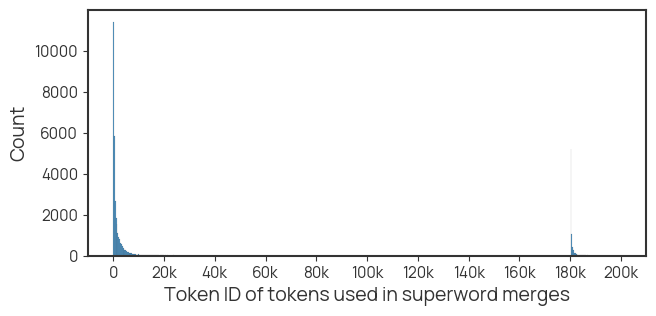

In [17]:
fig, ax = plt.subplots(figsize=(6.4, 3))
sns.histplot(used_tokens)
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])
ax.set_xlabel("Token ID of tokens used in superword merges")
plt.tight_layout(pad=0.1)
plt.savefig("plots/subword_token_ids.png", dpi=300)

# How many superword tokens are learned in Stage 2?

In [18]:
vocab_size = 200000
vocab_size_str = f"{vocab_size // 1000}K"
transition_points = []
for dirname in os.listdir('tokenizer_json'):
    match = re.match(rf'olmo2_p99_truncate_10G_(\d+)K_extend_{vocab_size_str}_mw4_colon', dirname)
    if match:
        num_inherit = int(match.group(1)) * 1000
        transition_points.append(num_inherit)

superbpe_tokenizers = {}
for transition_point in transition_points:
    transition_point_str = f"{transition_point // 1000}K"
    try:
        superbpe_tokenizers[transition_point] = Tokenizer.from_file(f"tokenizer_json/olmo2_p99_truncate_10G_{transition_point_str}_extend_{vocab_size_str}_mw4_colon/tokenizer.json")
    except:
        continue
    superbpe_tokenizers[transition_point].decoder = ByteLevel(add_prefix_space=True, trim_offsets=True, use_regex=True)

In [19]:
pattern = get_pretokenization_regex(f"tokenizer_json/olmo2_p99_truncate_pretok_10G_200K/tokenizer.json")
first_merged_token_id = 243

data = []
for transition_point, tokenizer in superbpe_tokenizers.items():
    superwords = []
    for token, token_id in tokenizer.get_vocab().items():
        text = tokenizer.decode([token_id])
        matches = [(match.group(), match.span()) for match in re.finditer(pattern, text)]
        if len(matches) > 1:
            superwords.append(token)
    data.append({
        "transition_point": transition_point,
        "superword_tokens": superwords,
        "num_superwords": len(superwords),
        "prop_multiword_in_stage2": len(superwords) / (vocab_size - transition_point - first_merged_token_id)
    })

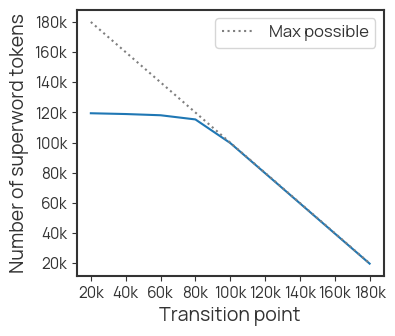

In [20]:
fig, ax = plt.subplots(figsize=(3.8, 3.2))
ts = [r['transition_point'] for r in data]
sns.lineplot(data=pd.DataFrame(data), x="transition_point", y="num_superwords")
sns.lineplot(x=ts, y=[vocab_size - t for t in ts], color=sns.color_palette()[-3], linestyle='dotted', label='Max possible')

ax.set_ylabel('Number of superword tokens')
ax.set_xlabel("Transition point")

xticks = range(20000, 180001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

yticks = range(20000, 180001, 20000)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{tick//1000}k" for tick in yticks])

plt.tight_layout(pad=0.1)
plt.savefig("plots/num_superword_tokens.png", dpi=300)
plt.savefig("plots/num_superword_tokens.pdf", dpi=300)

# Analysis of token frequency in data

In [21]:
def get_token_counter(tokenizer_name):
    token_to_id = read_json(f'tokenizer_json/{tokenizer_name}/tokenizer.json')['model']['vocab']
    id_to_token = {v: k for k, v in token_to_id.items()}
    encoded_dir = Path(f'analysis/encoded/{tokenizer_name}')
    token_counter = Counter()
    
    for f in os.listdir(encoded_dir):
        with open(encoded_dir / f) as fin:
            try:
                token_counter += Counter(json.load(fin))
            except:
                continue
    
    token_counter = Counter({id_to_token[int(k)]: v for k, v in token_counter.items() if int(k) < len(id_to_token)})
    return token_counter

In [22]:
vocab_size = 200000
vocab_size_str = f"{vocab_size // 1000}K"
transition_points = []
for dirname in os.listdir('tokenizer_json'):
    match = re.match(rf'olmo2_p99_truncate_10G_(\d+)K_extend_{vocab_size_str}_mw4_colon', dirname)
    if match:
        num_inherit = int(match.group(1)) * 1000
        transition_points.append(num_inherit)

transition_points = sorted(transition_points)
transition_points = [80000, 160000, 180000]
superbpe_counters = {}
for transition_point in transition_points:
    transition_point_str = f"{transition_point // 1000}K"
    tokenizer_name = f"olmo2_p99_truncate_10G_{transition_point_str}_extend_{vocab_size_str}_mw4_colon"
    try:
        superbpe_counters[transition_point] = get_token_counter(tokenizer_name)
    except FileNotFoundError:
        continue

In [23]:
bpe_tokenizer_name = "olmo2_p99_truncate_pretok_10G_200K"
bpe_token_counts = get_token_counter(bpe_tokenizer_name)

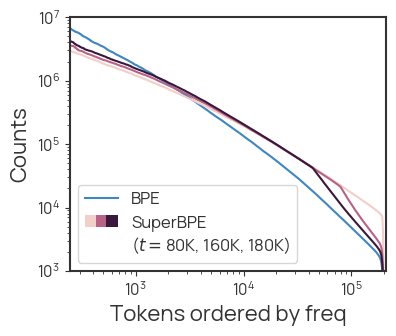

In [24]:
fig, ax = plt.subplots(figsize=(3.8, 3.2))
palette = sns.cubehelix_palette(start=3.26, n_colors=len(superbpe_counters), rot=0.3, hue=1.0)

bpe_counts_sum = sum(bpe_token_counts.values())
bpe_token_props = {i: y for i, (x, y) in enumerate(bpe_token_counts.most_common())}
x, y = zip(*list(bpe_token_props.items()))
sns.lineplot(x=x, y=y, label='BPE', color="#4086BF", ax=ax)

curriculum_colors = []
for i, (transition_point, superbpe_token_counts) in enumerate(superbpe_counters.items()):
    superbpe_counts_sum = sum(superbpe_token_counts.values())
    superbpe_token_props = {i: y for i, (x, y) in enumerate(superbpe_token_counts.most_common())}
    x, y = zip(*list(superbpe_token_props.items()))
    color = palette[i]
    sns.lineplot(x=x, y=y, color=color, ax=ax)
    curriculum_colors.append(color)

legend_handles, legend_labels = ax.get_legend_handles_labels()
gradient_patch = mpatches.Patch(facecolor='none', edgecolor='none', linewidth=0)
legend_handles.append(gradient_patch)
legend_labels.append(f'SuperBPE\n($t=$80K, 160K, 180K)')

cmap = ListedColormap(curriculum_colors)
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={mpatches.Patch: GradientHandler(cmap, num_stripes=20, adjust_stripe_ycenter=0.9)},
)

plt.xscale("log")
plt.yscale("log")
ax.set_xlim(left=first_merged_token_id, right=210000)
ax.set_ylim(top=10**7, bottom=10**3)
ax.set_ylabel('Counts', fontsize=16)
ax.set_xlabel('Tokens ordered by freq', fontsize=16)
plt.tight_layout(pad=0.1)
plt.savefig("plots/token_counts.png", dpi=300)
plt.savefig("plots/token_counts.pdf", dpi=300)

In [26]:
def fraction_of_items(counter, threshold=0.9, sorted_by="freq", tokenizer_name=None):
    total_count = sum(counter.values())  # total count of all items
    if sorted_by == "freq":
        sorted_items = counter.most_common()  # items sorted by count in descending order
    elif sorted_by == "id":
        token_to_id = read_json(f'tokenizer_json/{tokenizer_name}/tokenizer.json')['model']['vocab']
        id_to_token = {i: tok for tok, i in token_to_id.items()}
        sorted_items = [(id_to_token[i], counter[id_to_token[i]]) for i in range(len(token_to_id))]
    
    cumulative_count = 0
    num_tokens = 0
    
    # calculate cumulative count until reaching threshold
    for item, count in sorted_items:
        cumulative_count += count
        num_tokens += 1
        if cumulative_count >= threshold * total_count:
            break
    
    # return fraction of items making up the threshold percent of the count
    return num_tokens / len(counter)

In [27]:
# fraction of tokens needed to encode 99% of the data
fraction_of_items(superbpe_counters[80000], threshold=0.99)

0.8997903962461419

In [28]:
fraction_of_items(superbpe_counters[180000], threshold=0.99)

0.702251855705168

In [29]:
fraction_of_items(bpe_token_counts, threshold=0.99)

0.573318660430683

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

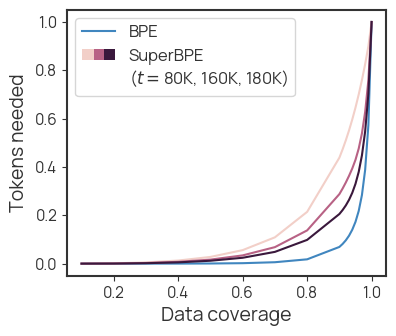

In [ ]:
fig, ax = plt.subplots(figsize=(3.8, 3.2))

x, y = [], []
for threshold in tqdm(list(np.arange(0.1, 1.0, 0.1)) + list(np.arange(0.9, 1.01, 0.01))):
    x.append(threshold)
    y.append(fraction_of_items(bpe_token_counts, threshold=threshold, sorted_by="freq"))

plot = sns.lineplot(x=x, y=y, color="#4086BF", label="BPE", ax=ax)

curriculum_colors = []
for i, (transition_point, superbpe_token_counts) in enumerate(superbpe_counters.items()):
    x, y = [], []
    for threshold in tqdm(list(np.arange(0.1, 1.0, 0.1)) + list(np.arange(0.9, 1.01, 0.01))):
        x.append(threshold)
        y.append(fraction_of_items(superbpe_token_counts, threshold=threshold, sorted_by="freq"))
    color = palette[i]
    plot = sns.lineplot(x=x, y=y, color=color, ax=ax)
    curriculum_colors.append(color)

legend_handles, legend_labels = ax.get_legend_handles_labels()
gradient_patch = mpatches.Patch(facecolor='none', edgecolor='none', linewidth=0)
legend_handles.append(gradient_patch)
legend_labels.append('SuperBPE\n($t=$80K, 160K, 180K)')

cmap = ListedColormap(curriculum_colors)
legend = ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={mpatches.Patch: GradientHandler(cmap, num_stripes=20, adjust_stripe_ycenter=0.9)},
)

ax.set_xlabel("Data coverage")
ax.set_ylabel("Tokens needed")
plt.tight_layout(pad=0.1)
plt.savefig("plots/data_covering.png", dpi=300)
plt.savefig("plots/data_covering.pdf", dpi=300)

In [33]:
token_to_id = read_json(f'tokenizer_json/{bpe_tokenizer_name}/tokenizer.json')['model']['vocab']
bpe_id_to_token = {i: tok for tok, i in token_to_id.items()}
superbpe_tokenizer_name = "olmo2_p99_truncate_10G_80K_extend_200K_mw4_colon"
token_to_id = read_json(f'tokenizer_json/{superbpe_tokenizer_name}/tokenizer.json')['model']['vocab']
superbpe_id_to_token = {i: tok for tok, i in token_to_id.items()}

x, y1, y2 = [], [], []
for i in range(len(token_to_id)):
    x.append(i)
    token = bpe_id_to_token[i]
    y1.append(bpe_token_counts[token])
    token = superbpe_id_to_token[i]
    y2.append(superbpe_counters[80000][token])

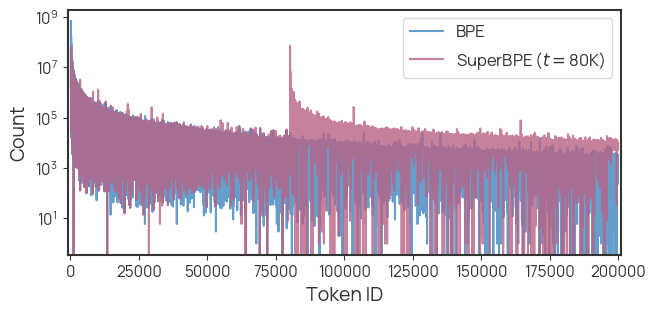

In [ ]:
num_tokens_to_show = 200000
fig, ax = plt.subplots(figsize=(6.4, 3))
plot = sns.lineplot(
    x=x[first_merged_token_id:first_merged_token_id+num_tokens_to_show],
    y=y1[first_merged_token_id:first_merged_token_id+num_tokens_to_show],
    label='BPE',
    color="#4086BF",
    alpha=0.8,
    ax=ax
)
plot = sns.lineplot(
    x=x[first_merged_token_id:first_merged_token_id+num_tokens_to_show],
    y=y2[first_merged_token_id:first_merged_token_id+num_tokens_to_show],
    label='SuperBPE ($t=$80K)',
    color="#b86285",
    alpha=0.8,
    ax=ax
)
plot.set(yscale="log")

ax.legend()
ax.set_xlim(left=-1000, right=201000)
ax.set_xlabel("Token ID")
ax.set_ylabel("Count")
plt.tight_layout(pad=0.1)
plt.savefig("plots/token_counts_ordered_by_id.pdf", dpi=300)

# Token length distribution (in chars)

In [36]:
tokenizer_name = "olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon"
token_to_id = read_json(f'tokenizer_json/{tokenizer_name}/tokenizer.json')['model']['vocab']
id_to_token = {v: k for k, v in token_to_id.items()}

In [37]:
token_lens = [len(token) for token in token_to_id]

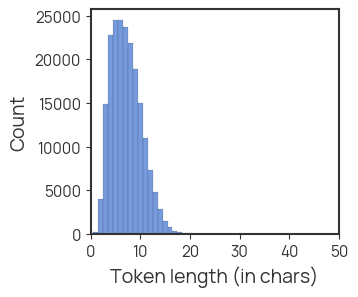

In [38]:
fig, ax = plt.subplots(figsize=(3.8, 3.2))
sns.histplot(token_lens, color=sns.color_palette('muted')[0], discrete=True)
ax.set_xlim(left=0, right=50)
ax.set_xlabel("Token length (in chars)")
plt.tight_layout()

# Check interference with eval format

In [39]:
tokenizer_name = "olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon"
tokenizer = Tokenizer.from_file(f"tokenizer_json/{tokenizer_name}/tokenizer.json")

In [40]:
token_to_id = read_json(f'tokenizer_json/{tokenizer_name}/tokenizer.json')['model']['vocab']
id_to_token = {v: k for k, v in token_to_id.items()}

In [41]:
len([token for token in token_to_id.keys() if token.isdigit() and len(token) == 3])

1000

In [42]:
tokenizer.encode('100').tokens

['100']

In [43]:
tokenizer.encode("""Answer: A""").tokens

['Answer:', 'ĠA']

In [44]:
for letter in ["A", "B", "C", "D", "E"]:
    print(tokenizer.encode(f'Answer: {letter}\n\n').tokens)

['Answer:', 'ĠAĊ', 'Ċ']
['Answer:', 'ĠBĊ', 'Ċ']
['Answer:', 'ĠC', 'Ċ', 'Ċ']
['Answer:', 'ĠD', 'Ċ', 'Ċ']
['Answer:', 'ĠE', 'Ċ', 'Ċ']


# Analyze multiword tokens

In [45]:
tokenizer_name = "olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon"

In [46]:
token_df = pd.read_json(f'tokenizer_json/{tokenizer_name}/token_pos.jsonl', lines=True)
token_df['pos'] = [tuple([POS_TO_GROUP.get(p, p) for p in pos]) for pos in token_df.pos]

In [47]:
multiword_dist = token_df['num_words'].value_counts().to_dict()
multiword_dist

{1: 183496, 2: 11366, 3: 4180, 4: 614, 0: 344}

[Text(0, 0, '0'),
 Text(0, 20000, '20K'),
 Text(0, 40000, '40K'),
 Text(0, 60000, '60K'),
 Text(0, 80000, '80K'),
 Text(0, 100000, '100K'),
 Text(0, 120000, '120K'),
 Text(0, 140000, '140K'),
 Text(0, 160000, '160K'),
 Text(0, 180000, '180K')]

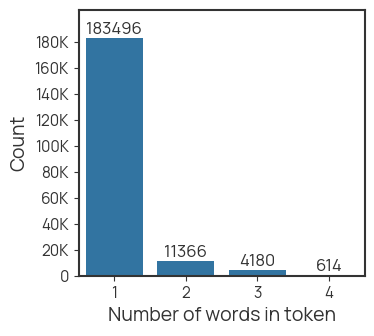

In [ ]:
fig, ax = plt.subplots(figsize=(3.8, 3.2))
ax = sns.barplot(x=multiword_dist.keys(), y=multiword_dist.values())
ax.bar_label(ax.containers[0], fontsize=12)
ax.set_xlabel("Number of words in token")
ax.set_ylabel("Count")
ax.set_xlim(left=0.5, right=4.5)
ax.set_ylim(top=205000)
plt.tight_layout(pad=0.1)
yticks = range(0, 180001, 20000)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{tick//1000}K" if tick != 0 else "0" for tick in yticks])
plt.savefig("plots/multiword_dist.png", dpi=300)
plt.savefig("plots/multiword_dist.pdf", dpi=300)